# Through-slice dephasing quantification for increaseing TE

In this Notebook the quantification of mainly signal loss will be investigated. As an addition, the shifting due to the direction of k-space read-out will also be investigated, which relates to the in-plane geometric distorition.

## Signal loss
As the readout-direction of k-space induces a shift of the boundaries in opposite directions, only the odd echos will be used to investigate and compare signal loss over different TE times.

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# Set LaTeX to render with Computer Modern font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering


In [6]:
# Folder for all data
folder_data = '/Users/hannerokstad/Desktop/Project_NTNU/Data/BILLY_PHANTOM_24_10_10-11_10_40-DST-1_3_12_2_1107_5_2_0_79123/JOHANNA_LAURAPHD_20241010_111131_730000/'

# Folder with images for this analysis
folder_TE = 'Slice_thickness_TE/MGE_9TE_1P5MM_250HZ_0026/'

In [7]:
# Function for cropping image
def crop_image(image, x1, x2, y1, y2):
    '''
    Function for cropping an image.
    
    Input:
    image: 2D numpy array
    x1, x2, y1, y2 (int): Coordinates for cropping
    
    Output:
    Cropped image
    '''
    return image[x1:x2, y1:y2]

In [8]:
def load_images_signal_loss(folder_TE, num_echos, x1, x2, y1, y2):
    '''
    Load images for signal loss analysis

    Input:
    folder_TE (str): Folder with images for this analysis
    num_echos (int): Number of echos acquired
    x1 (int): Starting x-coordinate for cropping
    x2 (int): Ending x-coordinate for cropping
    y1 (int): Starting y-coordinate for cropping
    y2 (int): Ending y-coordinate for cropping

    Output:
    images (list): List of all images
    images_cropped (list): List of all cropped images
    '''

    # List for storing all images
    images = []
    images_cropped = []

    # Directory to each echo time image
    for i in range(num_echos): # Acquired with 9 echos
    
        # Get images with 1.5 mm slice thickness, 250Hz bandwidth
        dir_TE = '9TE_1P5MM_250HZ_0026_e' + str(i + 1) + '.nii.gz'
        data = nib.load(folder_data + folder_TE + dir_TE)

        # Load the full images
        img = np.rot90(data.get_fdata(), 1) # Image stack is initially rotated
        images.append(img)

        # Make a cropped version for analysis
        img_cropped = crop_image(img, x1, x2, y1, y2)
        images_cropped.append(img_cropped)

    return images, images_cropped

In [9]:
# List of the different TE values
TE = [4.55, 8.81, 13.07, 17.33, 21.59, 25.85, 30.11, 34.37, 38.63]

# Cropping parameters
x1 = 150
x2 = 340
y1 = 125
y2 = 375

In [10]:
# Load the images
images, images_cropped = load_images_signal_loss(folder_TE, 9, 150, 340, 125, 375)

In [11]:
# Get the reference image slices (first echo)
ref_img = images[0]
ref_img_cropped = images_cropped[0]

In [12]:
def mask_ROI(img_idx):
    '''
    Mask the region of interest (ROI) on the reference image in red with defined mask

    Input:
    img_idx (int): Index of the image to mask

    Output:
    masked_img (np.array): Image with ROI
    '''

    # Load the defined ROI for the image
    mask = np.load(f'../ROI/through_slice/idx{img_idx}.npy')
    roi = mask > 0

    ref_img = ref_img_cropped[:, :, img_idx] 

    masked_img = ref_img.copy()

    masked_img[roi] = np.nan

    return masked_img

### Difference map

In [13]:
def plot_diff_map_signal_loss(images_cropped, echos, img_idx):
    '''
    Plot the difference maps for signal loss analysis

    Input:
    images_cropped (list): List of all cropped images
    echos (list): List of echos to plot
    img_idx (int): Index of the image to plot
    '''

    # Values for colorbars
    min_val_img = np.min([np.min(images_cropped[i][:, :, 7]) for i in echos])
    max_val_img = np.max([np.max(images_cropped[i][:, :, 7]) for i in echos])

    min_val_diff = np.min([np.min(images_cropped[i][:, :, img_idx] - ref_img_cropped[:, :, img_idx]) for i in echos[1:]])
    max_val_diff = np.max([np.max(images_cropped[i][:, :, img_idx] - ref_img_cropped[:, :, img_idx]) for i in echos[1:]])

    # Create a GridSpec with 2 rows and 4 columns
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05])

    axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]
    cax1 = fig.add_subplot(gs[0, 3])
    cax2 = fig.add_subplot(gs[1, 3])

    for i in range(len(echos)):
        axs[i].set_title('TE = ' + str(TE[echos[i]]) + 'ms', fontsize = 16)
        img = axs[i].imshow(images_cropped[echos[i]][:, :, img_idx], cmap = 'gray', vmin = min_val_img, vmax = max_val_img)
        axs[i].axis('off')

    # Make masked image
    masked_img = mask_ROI(img_idx)

    # Plot the mask/ROI
    cmap = mpl.colormaps.get_cmap('gray')
    cmap.set_bad('red')
    axs[3].set_title('ROI', fontsize=16)
    axs[3].imshow(masked_img, cmap=cmap)
    axs[3].axis('off')

    # In the two remaining figures plot the difference images
    for i in range(1, 3):
        if i == 1:
            axs[i + 3].set_title(r'TE$_5$ - TE$_1$', fontsize=16)
        else:
            axs[i + 3].set_title(r'TE$_9$ - TE$_1$', fontsize=16)
        diff_img = axs[i + 3].imshow(images_cropped[echos[i]][:, :, img_idx] - ref_img_cropped[:, :, img_idx], cmap='gray', vmin=min_val_diff, vmax=max_val_diff)
        axs[i + 3].axis('off')

    # Add colorbars
    cbar = fig.colorbar(img, cax=cax1, fraction=0.021, pad=0.04)
    cbar1 = fig.colorbar(diff_img, cax=cax2, fraction=0.021, pad=0.04)

    cbar.set_label('A.U.', rotation=0, labelpad = 15)
    cbar1.set_label('A.U.', rotation=0, labelpad = 15)

    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    plt.show()

In [14]:
# Slice index to plot
img_idx = 7

# Which echos to plot
echos = [0, 4, 8] # Echos 1, 5 and 9

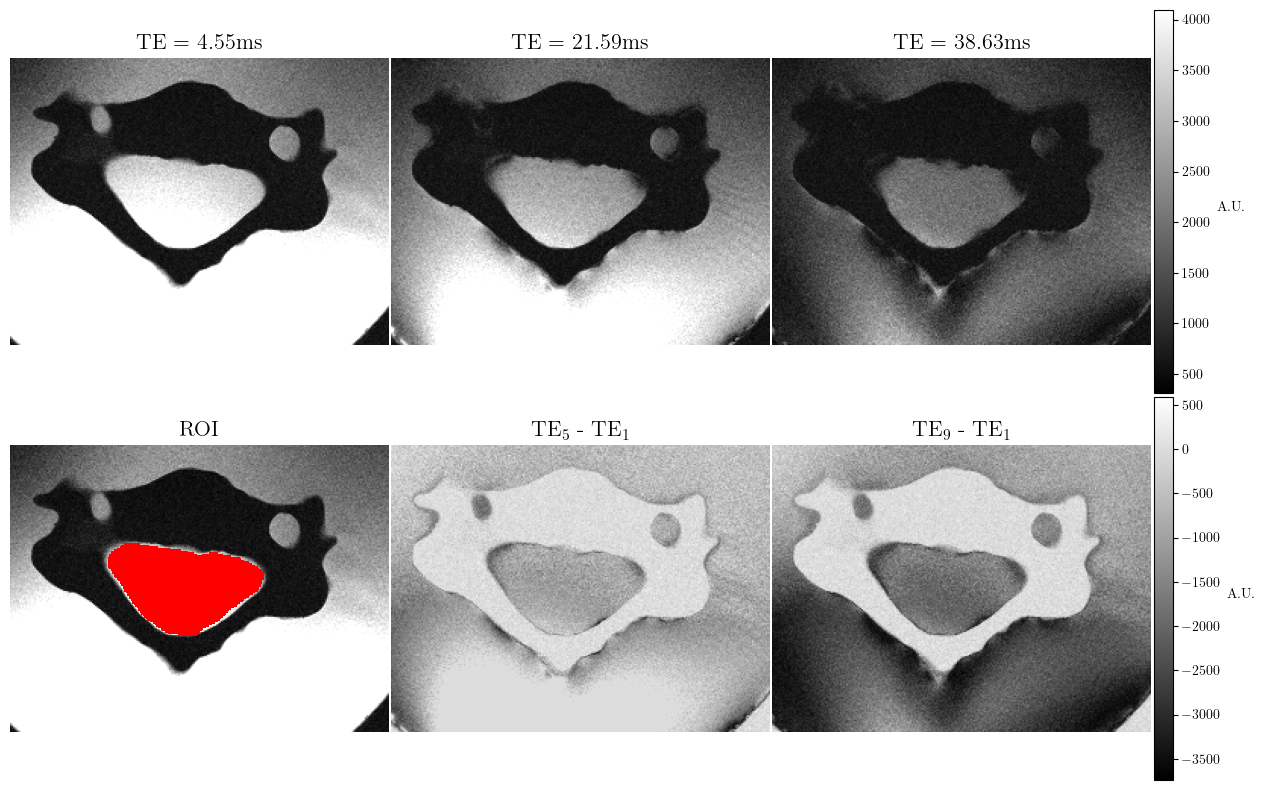

In [15]:
# Plot the images and difference maps for an axial slice of specified echos
plot_diff_map_signal_loss(images_cropped, echos, img_idx)

### Intensity ratio

In [16]:
def plot_intensity_ratio_signal_loss(histo_idicies):
    '''
    Plot the intensity ratio images for signal loss analysis, two histograms of low and hihg degree of signal loss and calculate the metrics for the itnensity ratios

    Input:
    global_threshold (float): Global threshold for signal loss
    all_threshold (float): Threshold for signal loss for all slices
    histo_idicies (list): List of indices for the slices to plot histograms of a low and high degree of signal loss

    Output:
    percentile_10_all (float): 10th percentile of all slices
    percentile_10_global (float): 10th percentile of global slices
    percentile_10_local (list): 10th percentile of local slices
    mean_dI (list): Mean intensity ratio for each slice
    std_dI (list): Standard deviation of intensity ratio for each slice
    median_dI (list): Median intensity ratio for each slice
    voxels_below_global (list): Percentage of voxels below global threshold for each slice
    voxels_below_10_all (list): Percentage of voxels below all threshold for each slice
    '''
    num_slices = images_cropped[0].shape[2]

    # Define the figure size and number of rows/colums in the grid
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(5, 4, width_ratios=[1, 1, 1, 0.05]) # Fourth column for colorbar

    # Initial values for colorbar
    vmin = np.inf
    vmax = -np.inf

    # Lists to save all intensity ratios and 10th percentile values for each slice
    dI_all = []
    percentile_10_local = []

    # Saving metrics
    mean_dI = []
    std_dI = []
    median_dI = []
    voxels_below_global = []
    voxels_below_10_all = []

    # First pass to find global min and max for colorbar
    for k in range(num_slices):
        # Get the mask for the ROI
        mask = np.load(f'../ROI/through_slice/idx{k}.npy')
        roi = mask > 0

        e1 = ref_img_cropped[:, :, k].copy()
        e9 = images_cropped[8][:, :, k].copy()

        # Set ROI to nan
        e1[~roi] = np.nan
        e9[~roi] = np.nan

        # Get intensity ratio
        dI = e9 / e1
        dI_all.append(dI)

        # Update min and max values if necessary
        vmin = min(vmin, np.nanmin(dI))
        vmax = max(vmax, np.nanmax(dI))

        # Metrics of dI
        percentile_10_local.append(np.nanpercentile(dI, 10))
        mean_dI.append(np.nanmean(dI))
        std_dI.append(np.nanstd(dI))
        median_dI.append(np.nanmedian(dI))

    # Determine global 10th percentile
    percentile_10_global = np.nanpercentile([np.nanpercentile(dI_all[k], 10) for k in range(num_slices)], 10)

    all_voxels = np.concatenate([dI_all[k] for k in range(num_slices)])

    # Get 10th percentile over all slices combined
    percentile_10_all = np.nanpercentile(all_voxels, 10)

    # Second pass to plot the intensity ratios
    axs = [fig.add_subplot(gs[i, j]) for i in range(5) for j in range(3)]

    for k in range(num_slices):
        # Get the eprcentage of voxels below the threshold defined
        voxels_below_global.append(np.nansum(dI < percentile_10_global) / np.sum(np.isfinite(dI)) * 100)
        voxels_below_10_all.append(np.nansum(dI < percentile_10_all) / np.sum(np.isfinite(dI)) * 100)
        if k < 3:
            # Add text to the first row of images
            axs[k].text(0.5, -2, f'{k}', fontsize=16, ha = 'center', va = 'center')
        im = axs[k].imshow(dI_all[k][50:150, 50:175], cmap='gray', vmin = vmin, vmax = vmax) # Images cropped to enlarge ROI in plot
        axs[k].axis('off')

    # Add a single colorbar for the entire figure
    cax = fig.add_subplot(gs[:, 3])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r'Intensity Ratio $\frac{e9}{e1}$', rotation=270, labelpad=20, fontsize=16)

    plt.tight_layout()
    plt.show()


    # Plot histogram over intensity ratio values for selected slices
    for i in histo_idicies:
        plt.figure()
        plt.hist(dI_all[i].flatten(), bins=100, range = [0.09, 0.75]) # Defined range to get the same scale for both histograms
        plt.axvline(percentile_10_global, color='red', linestyle='dashed', linewidth=2) 
        plt.axvline(percentile_10_all, color='green', linestyle='dashed', linewidth=2)
        plt.show()

    return percentile_10_all, percentile_10_global, percentile_10_local, mean_dI, std_dI, median_dI, voxels_below_global, voxels_below_10_all


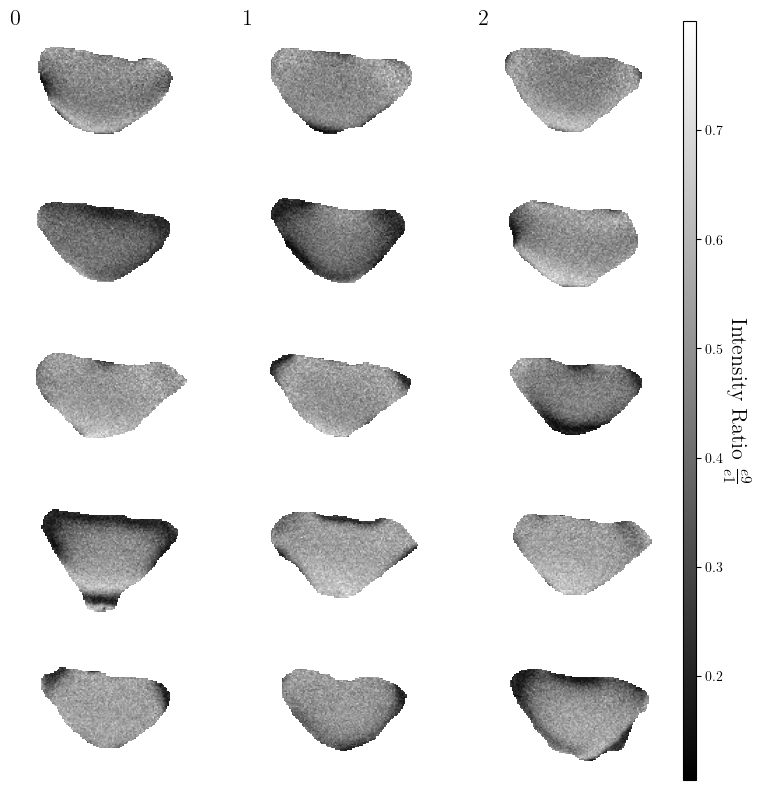

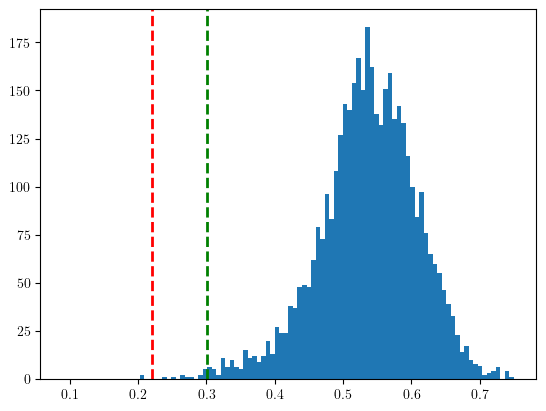

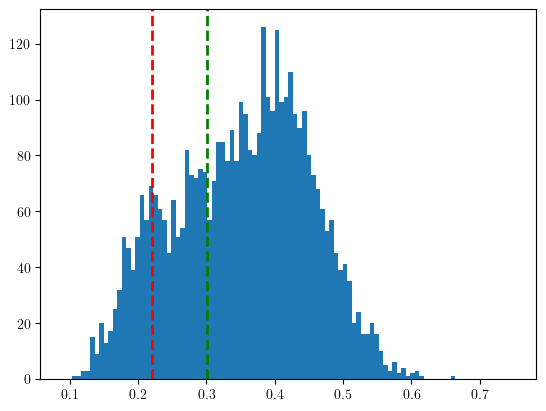

In [17]:
histo_idx_low = 11
histo_idx_high = 4
histo_indicies = [histo_idx_low, histo_idx_high]

# Calculate and plot the intensity ratio images for signal loss analysis, metrics saved in parameters
percentile_10_all, percentile_10_global, percentile_10_local, mean_dI, std_dI, median_dI, voxels_below_global, voxels_below_10_all = plot_intensity_ratio_signal_loss(histo_indicies)

### $T_2^*$-decay in voxels of interest

In [18]:
def plot_VOI(lower_right, lower_left, center, upper_left, upper_right):
    '''
    Plot the VOI on the reference image
    
    Input:
    lower_right (tuple): Coordinates for the lower right corner
    lower_left (tuple): Coordinates for the lower left corner
    center (tuple): Coordinates for the center
    upper_left (tuple): Coordinates for the upper left corner
    upper_right (tuple): Coordinates for the upper right corner
    '''
    plt.figure()
    plt.imshow(ref_img_cropped[:, :, 7], cmap='gray')
    cbar = plt.colorbar(shrink = 0.82)
    cbar.set_label('A.U.', rotation=0, labelpad = 15)
    plt.scatter(lower_right[0], lower_right[1], c='r', s=10) # Lower right
    plt.scatter(lower_left[0], lower_left[1], c='r', s=10) # Lower left
    plt.scatter(center[0], center[1], c='r', s=10) # Center
    plt.scatter(upper_left[0], upper_left[1], c='r', s=10) # Upper left
    plt.scatter(upper_right[0], upper_right[1], c='r', s=10) # Upper right
    plt.axis('off')
    plt.show()

In [19]:
def plot_evolution_decay(lower_right, lower_left, center, upper_left, upper_right, all_echos = True):
    '''
    Plot the evolution of the intensity values for the 5 voxels over all or only odd echos

    Input:
    lower_right (tuple): Coordinates for the lower right corner
    lower_left (tuple): Coordinates for the lower left corner
    center (tuple): Coordinates for the center
    upper_left (tuple): Coordinates for the upper left corner
    upper_right (tuple): Coordinates for the upper right corner
    all_echos (bool): If True, plot all echos, if False, plot only odd echos
    '''
    # Extract the intensity values of these 5 voxels for each echo time
    intensity_values = []
    for i in range(9):
        # NB: Indexing is opposite for numpy arrays vs imshow of image voxels!
        intensity_values.append([images_cropped[i][lower_right[1], lower_right[0], 7],
                                images_cropped[i][lower_left[1], lower_left[0], 7],
                                images_cropped[i][center[1], center[0], 7],
                                images_cropped[i][upper_left[1], upper_left[0], 7],
                                images_cropped[i][upper_right[1], upper_right[0], 7]])
        
    # Labels the indicies of intensity values
    voxel_labels = ['Lower right', 'Lower left', 'Center', 'Upper left', 'Upper right']

    if all_echos:
        # Plot the intensity values for all echos
        for i in range(5):
            plt.plot(TE, [intensity_values[j][i] for j in range(9)], label= voxel_labels[i])
            plt.xlabel('Echo time [ms]')
            plt.ylabel('Intensity value')
            plt.legend()
    else:
        # Plot only odd echos
        for i in range(5):
            plt.plot(TE[::2], [intensity_values[j][i] for j in range(0, 9, 2)], label=voxel_labels[i])
            plt.xlabel('Echo time [ms]')
            plt.ylabel('Intensity value')
            plt.legend()

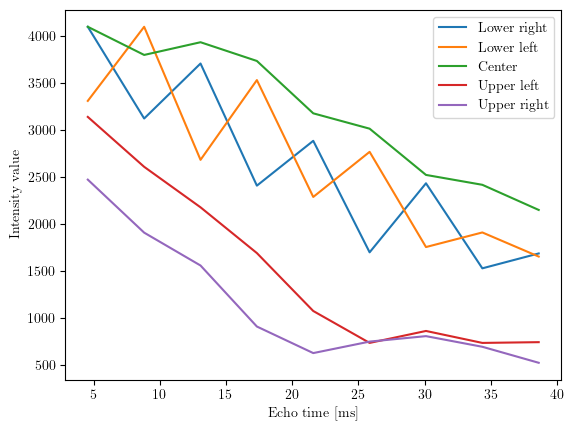

In [31]:
# Coordinates of voxels of interest
lower_right = (150, 107)
lower_left = (80, 105)
center = (115, 110)
upper_left = (65, 75)
upper_right = (163, 81)

# Change all_Echos to False to plot only odd echos
plot_evolution_decay(lower_right, lower_left, center, upper_left, upper_right, all_echos = True)

# Appendix

In [33]:
def plot_increasing_TE(img_idx):
    '''
    Function for plotting the same image slice over increasing TE values
    
    Input:
    img_idx (int): Index of the image to plot
    '''
    min_val_1 = np.min([np.min([images_cropped[i][:, :, img_idx]]) for i in range(9)])
    max_val_1 = np.max([np.max([images_cropped[i][:, :, img_idx]]) for i in range(9)])

    # Create a GridSpec with 3 rows and 4 columns
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(3, 4, width_ratios=[1, 1, 1, 0.05])

    axs = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

    # Plot all echos
    for i in range(9):
        if i == 0:
            axs[i].set_title('TE = ' + str(TE[i]) + 'ms', fontsize = 16)
            img = axs[i].imshow(ref_img_cropped[:, :, img_idx], cmap='gray')
            axs[i].axis('off')
            #elif i % 2 == 0:
        else:
            axs[i].set_title('TE = ' + str(TE[i]) + 'ms', fontsize = 16)
            img = axs[i].imshow(images_cropped[i][:, :, img_idx], cmap='gray', vmin = min_val_1, vmax = max_val_1)
            axs[i].axis('off')

    # Add common colorbar
    cax = fig.add_subplot(gs[:, 3])
    cbar = fig.colorbar(img, cax = cax, orientation='vertical', fraction=0.021, pad=0.04)
    cbar.set_label('A.U.', rotation=0, labelpad=15)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.01)
    plt.show()

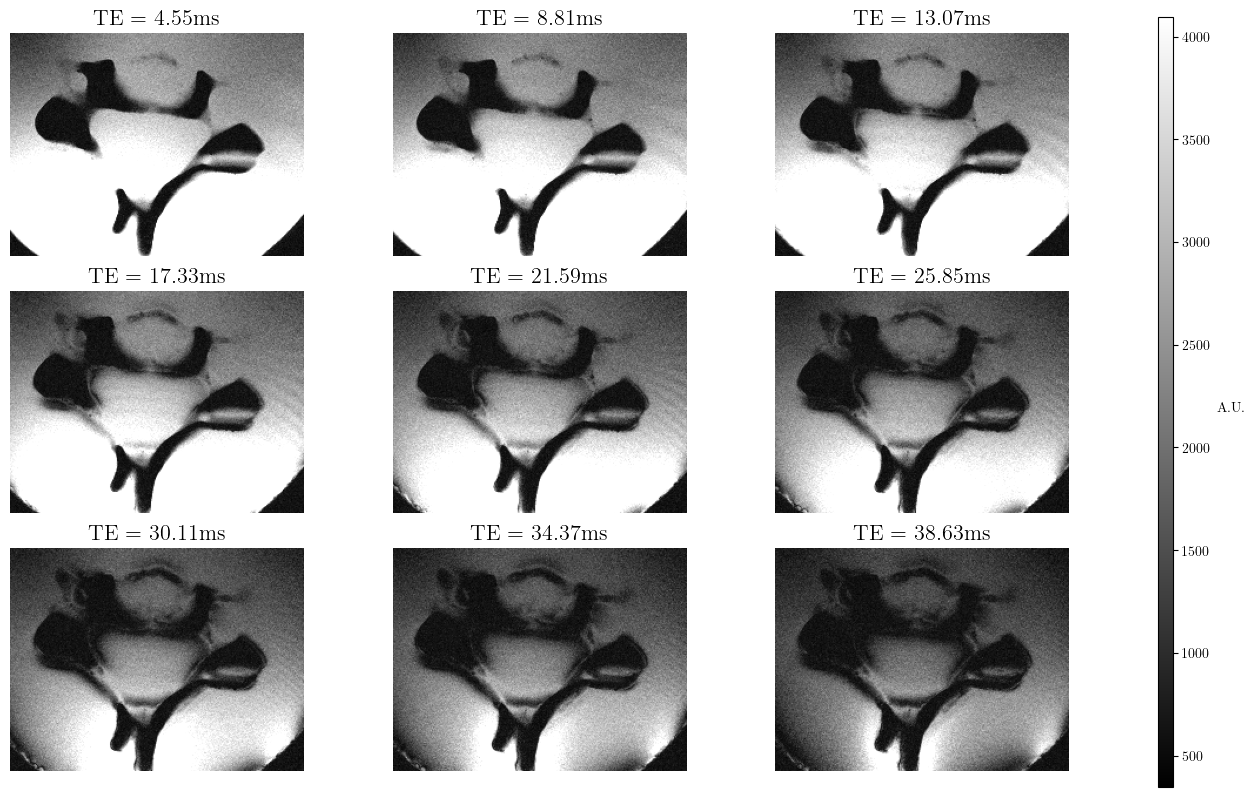

In [34]:
img_idx = 9
plot_increasing_TE(img_idx)